In [1]:
import math
import time


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.linalg as TLA
from tqdm import tqdm
from sklearn.covariance import GraphicalLasso, graphical_lasso

from fastPLNmodels.utils import init_C, init_M, init_Sigma, Poisson_reg, log_stirling, batch_log_P_WgivenY, MSE
from fastPLNmodels.utils import refined_MSE, RMSE, build_block_Sigma, sample_PLN
from fastPLNmodels.VRA import SAGARAD, SAGRAD, SVRGRAD 

if torch.cuda.is_available():
    device = torch.device('cuda')
else : 
    device = torch.device('cpu')
#device = torch.device('cpu') # have to deal with this. 
    

/home/bastien/anaconda3/envs/torch_env/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272155627/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [379]:
def ELBO(Y, O,covariates ,M ,S ,Sigma ,beta):
    '''Compute the ELBO (Evidence LOwer Bound. See the doc for more details 
    on the computation
    
    Args: 
        Y: torch.tensor. Samples with size (n,p)
        0: torch.tensor. Offset, size (n,p)
        covariates: torch.tensor. Covariates, size (n,d)
        M: torch.tensor. Variational parameter with size (n,p)
        S: torch.tensor. Variational parameter with size (n,p)
        Sigma: torch.tensor. Model parameter with size (p,p)
        beta: torch.tensor. Model parameter with size (d,p)
    Returns: 
        torch.tensor of size 1, with a gradient. The ELBO. 
    '''
    n,p = Y.shape
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    tmp = torch.sum( torch.multiply(Y, OplusM)  
                     -torch.exp(OplusM+SrondS/2) 
                     +1/2*torch.log(SrondS)
                   )
    DplusMmoinsXB2 = torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        DplusMmoinsXB2
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    return tmp



class fastPLN():
    '''Implement the variational algorithm infering the parameters of the PLN model,
    with a closed form for the M step and a gradient step for the VE step. Any value of n 
    and p can be taken.
    '''
    def __init__(self): 
        '''Defines some usefuls lists and variables for the object. A deeper initalization is done 
        in the init_data() func, once the dataset is available.
        '''
        self.old_loss = 1
        # some lists to store some stats
        self.running_times = list()
        self.deltas = list()
        self.norm_grad_M = list()
        self.norm_grad_S = list()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()

    def init_data(self, Y, O, covariates, good_init): 
        '''Initialize the parameters with the right shape given the data. 
        
        Args: 
              data: list with 3 elements(torch.tensor): Y, O and covariates in this 
              order. Y and O should be of size (n,p), covariates of size (n,d). 
        Returns:
            None but initialize some useful data. 
        '''
        #known variables
        try : 
            self.Y = torch.from_numpy(Y).to(device)
            self.O = torch.from_numpy(O).to(device)
            self.covariates = torch.from_numpy(covariates).to(device)
        except : 
            self.Y = Y.to(device)
            self.O = O.to(device)
            self.covariates = covariates.to(device)
        self.n, self.p = self.Y.shape
        self.d = self.covariates.shape[1]
        if good_init : 
            print('Initialization ...') 
            #model parameter 
            poiss_reg = Poisson_reg()
            poiss_reg.fit(self.Y, self.O, self.covariates)
            self.beta = torch.clone(poiss_reg.beta.detach()).to(device)
            self.Sigma =  init_Sigma(self.Y, self.O, self.covariates, self.beta).to(device)
            # Initialize C in order to initialize M. 
            self.C = torch.cholesky(self.Sigma).to(device)
            self.M = init_M(self.Y, self.O, self.covariates, self.beta,self.C, 300, 0.1) 
            self.M.requires_grad_(True)
            #self.M+= covariates@self.beta
            print('Initialization finished')
        else:
            self.beta = torch.randn((self.d,self.p))
            self.Sigma = torch.diag(torch.ones(self.p))
            self.M = torch.ones(self.n, self.p)
        
        self.inv_Sigma = torch.inverse(self.Sigma)
        self.sparse_cov, self.sparse_precision = graphical_lasso(self.Sigma.numpy(), alpha = self.reg*2/(self.n), cov_init = self.Sigma.numpy())
        # No better initialization possible for S
        self.S = 1/2*torch.ones((self.n,self.p)).to(device)
        
    
    def compute_ELBO(self): 
        '''Compute the ELBO with the parameter of the model.'''
        return ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    
    def compute_penalized_ELBO(self):
        '''Compute the penalized ELBO with the parameter of the model.'''
        return self.compute_ELBO() - self.reg*torch.norm(self.inv_Sigma, p = 1) 
    
    def fit(self,Y,O,covariates, N_iter_max= 200, tol_delta = None,tol_RMSE_M_grad =  0.1  ,
            optimizer = torch.optim.Rprop, lr = 0.1,good_init = True, verbose = False, reg = 1): 
        '''Main function of the class. Infer the best parameter Sigma and beta given the data.
        
        Args:
            Y: torch.tensor. Samples with size (n,p)
            0: torch.tensor. Offset, size (n,p)
            covariates: torch.tensor. Covariates, size (n,d)
            N_iter_max: int. The maximum number of iteration you are ready to do.
                Default is 200. 
            tol_delta: non negative float. Criterion for the model (Default is None).
                If tol_delta is None, then we will set it as 1/(2*p). If the RMSE 
                between the old parameters and the new ones are lower than tol_delta, 
                the algorithm will stop. 
            tol_RMSE_M_grad: non negative float. Criterion for the model (Default is 0.1). 
                If the RMSE of the gradient of M is lower than tol_RMSE_M_grad, the 
                algorithm will stop. 
            optimizer: objects that inherits from torch.optim. The optimize you want. 
                Default is torch.optim.Rprop.
            lr: positive float. The learning rate of the optimizer. Default is 0.1.
            good_init: bool. If True, we will do a smart initialization instead of 
                a random initialization. Default is True. 
            verbose: bool. If True, will print some stats during the fitting. Default is 
                False. 
            
        Returns: 
            None but update the parameter C and beta of the object.
        '''
    
        self.reg = reg
        self.t0 = time.time()
        #initialize the data
        self.init_data(Y,O,covariates, good_init)
        if tol_delta is None : 
            tol_delta = 1/(2*self.p)
        
        self.optimizer = optimizer([self.S,self.M], lr = lr)
        stop_condition = False 
        i = 0
        self.old_beta = torch.clone(self.beta.detach())
        self.old_Sigma = torch.clone(self.Sigma.detach())
        while i < N_iter_max and stop_condition == False: 
            self.i = i
            # VE step
            self.optimizer.zero_grad()
            self.M.grad = -self.grad_M()
            self.S.grad = -self.grad_S()
            self.optimizer.step()
            # M step
            self.beta = self.closed_beta()
            self.Sigma = self.closed_Sigma()
            
            # Keep in memory the inverse to avoid computing it too often
            self.inv_Sigma = torch.inverse(self.Sigma)
            
            # Criterions
            delta_beta = RMSE(self.old_beta-self.beta).item()
            delta_Sigma = RMSE(self.old_Sigma-self.Sigma).item()
            delta = delta_beta + delta_Sigma
            RMSE_M_grad = RMSE(self.M.grad).item()
            
            # condition to see if we have reached the tolerance threshold
            if  delta < tol_delta or RMSE_M_grad<tol_RMSE_M_grad:
                stop_condition = True 
            self.old_Sigma = torch.clone(self.Sigma)
            self.old_beta = torch.clone(self.beta)
            # print some stats if we want to
            if i%10 == 0 and verbose : 
                print('Iteration number: ', i)
                print('-------UPDATE-------')
                print('Delta : ', delta)
            i += 1
            # keep records
            self.keep_records(delta, RMSE_M_grad)
            
            
        if stop_condition : 
            print('Last delta: {}, last_RMSE_M : {} reached in {} iterations'.format(delta,RMSE_M_grad, i))
        else : 
            print('Maximum number of iterations reached : ', N_iter_max, 'last delta = ', delta)

    def keep_records(self, delta, RMSE_M_grad):
        '''Keep some records to plot after.'''
        self.norm_grad_M.append(RMSE_M_grad)
        self.norm_grad_S.append(RMSE(self.S.grad).item())
        self.deltas.append(delta)
        self.MSE_Sigma_list.append(MSE(self.Sigma-Sigma_sampling).item())
        self.MSE_beta_list.append(MSE(self.beta-true_beta).item())
        
        
        self.running_times.append(time.time()-self.t0)
    def grad_M(self):
        '''Compute the gradient of the ELBO with respect to M'''
        self.A = torch.exp(self.O+self.M+torch.multiply(self.S,self.S)/2)
        grad = self.Y - self.A
        grad -= torch.mm(self.M-torch.mm(self.covariates,self.beta), self.inv_Sigma)
        return grad 

    def grad_S(self): 
        '''Compute the gradient of the ELBO with respect to S'''
        grad = torch.div(1,self.S)
        grad -=torch.multiply(self.S, self.A)
        grad -=torch.mm(self.S, torch.diag(torch.diag(self.inv_Sigma)))
        return grad

    def closed_Sigma(self):
        '''Closed form for Sigma for the M step.'''
        n,p = self.M.shape
        MmoinsXB = self.M-torch.mm(self.covariates,self.beta)
        closed = torch.mm(MmoinsXB.T,MmoinsXB)
        closed +=torch.diag(torch.sum(torch.multiply(self.S,self.S), dim = 0))
        if self.reg > 0 and self.i > 10: 
            with torch.no_grad(): 
                if self.i == 11:
                    self.sparse_cov, self.sparse_precision = graphical_lasso(1/n*closed.numpy(), alpha = self.reg*2/(self.n))#.fit(Sigma_sampling)
                else: 
                    self.sparse_cov, self.sparse_precision = graphical_lasso(1/n*closed.numpy(), alpha = self.reg*2/(self.n), cov_init = self.sparse_cov)#.fit(Sigma_sampling)
                self.Sigma = torch.from_numpy(self.sparse_cov)
            return torch.from_numpy(self.sparse_cov)
        return 1/n*closed
    def closed_beta(self): 
        '''Closed form for beta for the M step.'''
        ## a améliorer l'inverse !
        return torch.mm(
                        torch.mm(
                                torch.inverse(torch.mm(
                                                    self.covariates.T,
                                                    self.covariates)),
                                self.covariates.T),
                        self.M) 
        
    def show_Sigma(self):
        '''Simple method that displays Sigma to see the global structure.'''
        sns.heatmap(self.Sigma.detach().numpy())
        plt.show()
    def init_M(self, N_iter, lr, eps = 7e-3):
        '''Initialization for the variational parameter M. Basically, we take 
        the mode of the log_posterior as initialization.
        
        Args: 
            N_iter: int. The maximum number of iteration you are ready to 
                do to find the mode. 
            lr: positive float. The learning rater of the optimizer. A good 
        '''
        def batch_un_log_posterior(W): 
            return batch_log_P_WgivenY(self.Y, self.O, self.covariates,  W, self.C, self.beta) 
        self.batch_un_log_posterior = batch_un_log_posterior
        W = torch.randn(self.n,self.p)
        W.requires_grad_(True)
        optimizer = torch.optim.Rprop([W], lr = lr)
        criterion = 2*eps
        old_W = torch.clone(W)
        keep_condition = True
        while  i < N_iter_max and keep_condition: 
            loss = -torch.mean(self.batch_un_log_posterior(W))
            loss.backward()
            optimizer.step()
            crit = torch.max(torch.abs(W-old_W))
            optimizer.zero_grad()
            if crit<eps and i > 2 : 
                keep_condition = False 
            old_W = torch.clone(W)
            i+=1
        print('nb iteration to find the mode: ', i)
        return W
    
    
    def show(self,name_doss = '' ,  save = False):
        '''displays some useful stats of the model. 

        args : 
            'model' fastPLN object where you have called model.fit_IMPS()
            'name_doss' : str. the name of the file you want to save the graphic. 
            'save' : bool. If True, the graphic will be saved. If false, won't be saved. 

        returns : 
                None but displays the figure. It can also save the figure if save = True. 
        '''
        fig,ax = plt.subplots(5,1,figsize = (15,15))
        abscisse = self.running_times
        plt.subplots_adjust(hspace = 0.4)

        # plot the L1 norm of the gradients. 
        ax[0].plot(abscisse, self.deltas, label = 'Deltas')
        ax[0].set_title('Delta Criteria')
        ax[0].set_yscale('log')
        ax[0].legend()


        ax[1].plot(abscisse, self.norm_grad_M, label = ' norm grad M ')
        ax[1].set_yscale('log')
        ax[1].legend()

        ax[2].plot(abscisse, self.norm_grad_S, label = ' norm grad S')
        ax[2].set_yscale('log')
        ax[2].legend()
        
        ax[3].plot(abscisse, self.MSE_Sigma_list, label = 'MSE Sigma')
        ax[3].set_yscale('log')
        ax[3].legend()
        
        ax[4].plot(abscisse, self.MSE_beta_list, label = 'MSE beta')
        ax[4].set_yscale('log')
        ax[4].legend()
        
        if save: 
            plt.savefig(name_doss)
        plt.show()

In [380]:
d = 2
n = 200;  p = 50
q = 20

In [381]:
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q))/3 #+ 0.5*torch.eye(p)
#true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
#true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p))*1.5

covariates = torch.randn((n,d))/1
O =  0+torch.zeros((n,p))
Y, Z,_  = sample_PLN(Sigma_sampling,true_beta, O, covariates)
Y = torch.from_numpy(Y)

In [411]:
fast = fastPLN()
reg = 2
%time fast.fit(Y, O, covariates, good_init = False, reg = reg)

/home/bastien/anaconda3/envs/torch_env/lib/python3.6/site-packages/sklearn/covariance/_graph_lasso.py:232: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.057600254037684095, tolerance: 0.003283331298143974
  check_random_state(None), False)
/home/bastien/anaconda3/envs/torch_env/lib/python3.6/site-packages/sklearn/covariance/_graph_lasso.py:232: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015894018563287204, tolerance: 0.004137621720138087
  check_random_state(None), False)
/home/bastien/anaconda3/envs/torch_env/lib/python3.6/site-packages/sklearn/covariance/_graph_lasso.py:232: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007247383536562069, tolerance: 0.002741832675016294
  check_random_state(None), False)
/home/bastien/anaconda3/envs/torch_env/lib/python3.6/site-packages/skl

Last delta: 0.00916969955877056, last_RMSE_M : 808.5966816321727 reached in 40 iterations
CPU times: user 44.2 s, sys: 871 ms, total: 45.1 s
Wall time: 5.7 s


In [417]:
fast_bis = fastPLN()
%time fast_bis.fit(Y, O, covariates, good_init = False, reg = 0)
#fast_bis.Sigma, fast_bis.sparse_precision = graphical_lasso(fast_bis.Sigma.numpy(), alpha = 1/10000*reg*n/2)


Last delta: 0.008751700485009384, last_RMSE_M : 313.8284904830618 reached in 42 iterations
CPU times: user 2.03 s, sys: 44.3 ms, total: 2.07 s
Wall time: 133 ms


In [413]:
torch.sum(fast.inv_Sigma ==0)

tensor(98)

<AxesSubplot:>

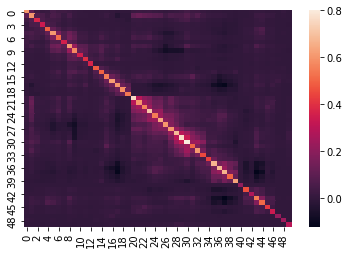

In [414]:
sns.heatmap(fast.Sigma)

<AxesSubplot:>

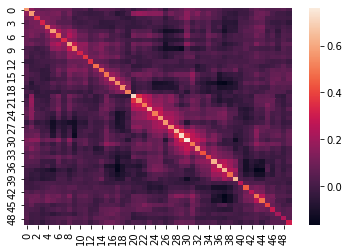

In [418]:
sns.heatmap(fast_bis.Sigma)

In [ ]:
torch.sum()

<AxesSubplot:>

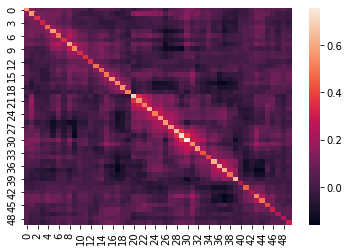

In [389]:
sns.heatmap(fast.Sigma)

In [319]:
fast.sparse_cov, fast.sparse_precision = graphical_lasso(fast.Sigma.numpy(), alpha = 10*n/2)

In [225]:
#fast.reg = 10
#fast.Sigma = torch.from_numpy(fast.sparse_cov)
fast.compute_penalized_ELBO().item()

16314236.057616614

In [22]:
print(fast.compute_ELBO().item())

152220450.3942192


<AxesSubplot:>

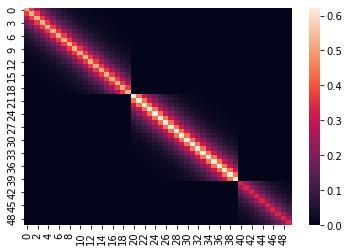

In [416]:
sns.heatmap(Sigma_sampling)

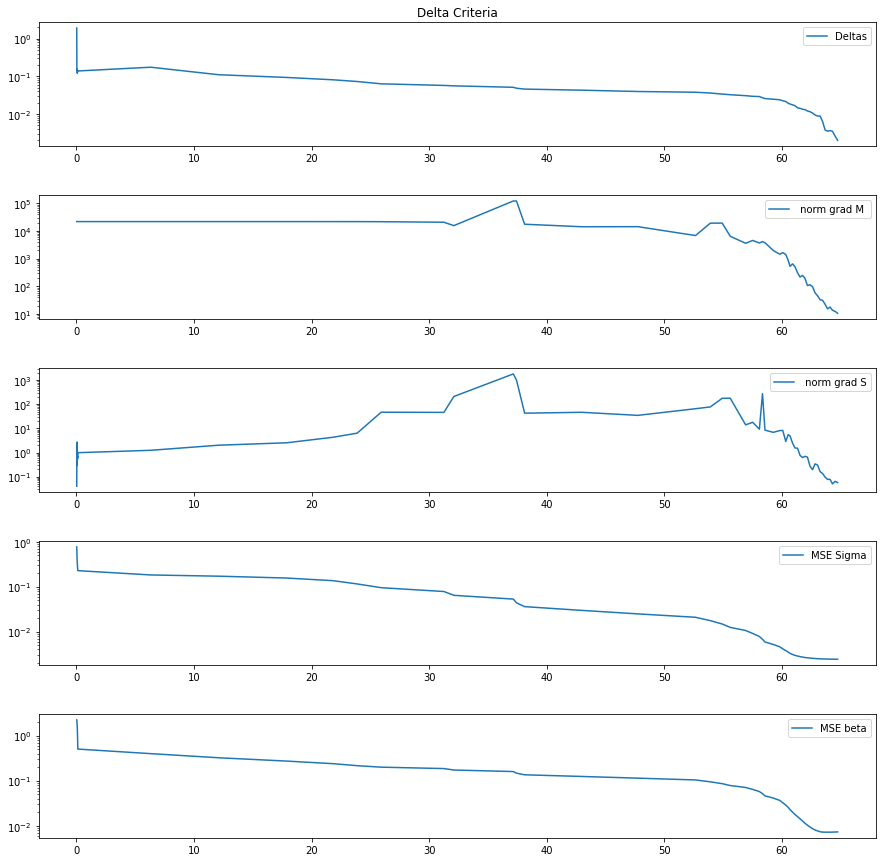

In [9]:
fast.show()

In [11]:
torch.sum(torch.inverse(fast.Sigma)!=0)

tensor(3391)

In [287]:
sparse_cov, sparse_precision = graphical_lasso(fast.Sigma.numpy(), alpha = 0.5)#.fit(Sigma_sampling)

In [289]:
np.sum(sparse_precision!= 0)

6174

<AxesSubplot:>

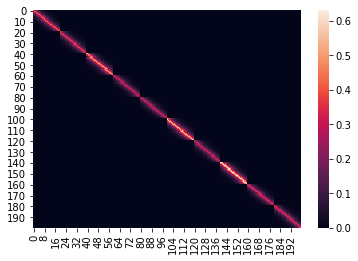

In [310]:
sns.heatmap(Sigma_sampling)

In [216]:
torch.sum(torch.inverse(fast.Sigma)==0)

tensor(0)